In [1]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [2]:
# Imports
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import pandas as pd
import numpy as np
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import earthpy.plot as ep
import os

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

2024-11-28 20:30:08.410835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732800608.421242   78445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732800608.424173   78445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:30:08.435530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Parameter
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
LABEL = ['classvalue']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#FF8C00', '#006400']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023_ALL.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Wonosobo_2023.tif'

/home/seviko/python/py311/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


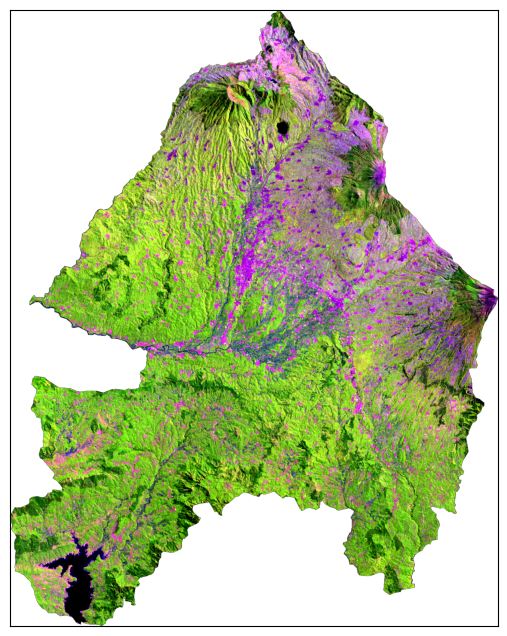

In [4]:
# Load image
image = rasterio.open(IMAGE_PATH)
height = image.height
width = image.width
shape = (height, width)

# (Optional) Visualize the image
image_vis = []
for x in [6, 5, 4]:
    image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
ep.plot_rgb(image_vis, figsize=(8, 8), stretch=True)
plt.show()

In [5]:
# Read samples
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac=1)
# Ensure label is integer type
samples['classvalue'] = samples['classvalue'].astype('int32')
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
1531,0.128034,0.155025,0.258081,0.331204,0.485341,0.452286,0.301146,0.166824,0.234200,0.035254,-0.305694,-0.035254,0.200602,0.188768,52,2,train
13741,0.013593,0.018570,0.034740,0.026462,0.221740,0.149415,0.064825,0.393311,0.547572,0.194865,-0.729102,-0.194865,0.394838,0.786767,6,8,train
9469,0.029433,0.039965,0.068373,0.061360,0.308640,0.184010,0.096560,0.448927,0.523396,0.252979,-0.637293,-0.252979,0.311687,0.668324,23,6,train
12282,0.021237,0.025500,0.057290,0.034658,0.296127,0.146637,0.055200,0.497916,0.685763,0.337628,-0.675794,-0.337628,0.453025,0.790453,9,7,train
5427,0.026875,0.033227,0.069032,0.056657,0.219183,0.111878,0.058335,0.310181,0.579594,0.324126,-0.520965,-0.324126,0.314563,0.589200,10,4,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12999,0.021815,0.027205,0.062707,0.040735,0.317770,0.152743,0.060233,0.509952,0.681312,0.350740,-0.670375,-0.350740,0.434370,0.772751,4,7,test
16085,0.032774,0.035620,0.049232,0.035400,0.222744,0.165379,0.072195,0.400995,0.510441,0.147801,-0.637965,-0.147801,0.392231,0.725734,10,8,test
1765,0.038466,0.049205,0.087994,0.087870,0.344225,0.243163,0.125476,0.426574,0.465719,0.172054,-0.592828,-0.172054,0.319245,0.593284,56,2,train
6721,0.035015,0.039470,0.074037,0.059737,0.380030,0.254987,0.123950,0.555127,0.508115,0.196912,-0.673892,-0.196912,0.345802,0.728322,54,5,train


In [6]:
# Split into train and test based on 'sample' column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Prepare data for TFDF
train_data = train[FEATURES + LABEL]
test_data = test[FEATURES + LABEL]

In [7]:
filtered_train = train[FEATURES + LABEL]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]

print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())

Label 1 848
Label 2 1052
Label 3 1102
Label 4 1960
Label 5 603
Label 6 2981


In [8]:
# Convert to TensorFlow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=LABEL[0])
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=LABEL[0])

I0000 00:00:1732800615.432346   78445 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:10:00.0, compute capability: 8.6


In [9]:
best_num_trees = 50
best_max_depth = 10
best_min_examples = 2

# Define and train the best model
rf_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=best_num_trees,
    max_depth=best_max_depth,
    min_examples=best_min_examples
)

rf_model.fit(train_ds)

# Evaluate the best model
best_evaluation = rf_model.evaluate(test_ds, return_dict=True)
print(f"Best Model Evaluation: {best_evaluation}")

Use /tmp/tmpdh8lvtx8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.046356. Found 14853 examples.
Training model...


I0000 00:00:1732800620.045405   78445 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1732800620.052853   78445 kernel.cc:783] Collect training examples
I0000 00:00:1732800620.052876   78445 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1732800620.053128   78445 kernel.cc:401] Number of batches: 15
I0000 00:00:1732800620.053139   78445 kernel.cc:402] Number of examples: 14853
I0000 00:00:1732800620.054241   78445 kernel.cc:802] Training dataset:
Number of records: 14853
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	0: "B1" NUMERICAL mean:0.0291

Model trained in 0:00:00.387380
Compiling model...


I0000 00:00:1732800620.295180   78984 random_forest.cc:811] Training of tree  42/50 (tree index:38) done accuracy:0.916717 logloss:0.604663
I0000 00:00:1732800620.324908   78985 random_forest.cc:811] Training of tree  50/50 (tree index:49) done accuracy:0.919276 logloss:0.562223
I0000 00:00:1732800620.325098   78969 random_forest.cc:891] Final OOB metrics: accuracy:0.919276 logloss:0.562223
I0000 00:00:1732800620.330077   78969 kernel.cc:926] Export model in log directory: /tmp/tmpdh8lvtx8 with prefix c63e0a72c0cd4055
I0000 00:00:1732800620.344551   78969 kernel.cc:944] Save model in resources
I0000 00:00:1732800620.356328   78445 abstract_model.cc:914] Model self evaluation:
Number of predictions (without weights): 14853
Number of predictions (with weights): 14853
Task: CLASSIFICATION
Label: __LABEL

Accuracy: 0.919276  CI95[W][0.915504 0.922925]
LogLoss: : 0.562223
ErrorRate: : 0.0807244

Default Accuracy: : 0.2007
Default LogLoss: : 2.08705
Default ErrorRate: : 0.7993

Confusion Tab

Model compiled.
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00
Best Model Evaluation: {'loss': 0.0}


In [10]:
# Evaluate the model
evaluation = rf_model.evaluate(test_ds)
print(f"Model evaluation: {evaluation}")

5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Model evaluation: 0.0


5/5 [==============================] - 0s 8ms/step


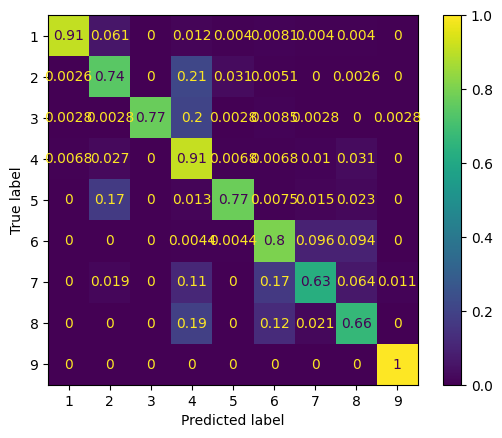

              precision    recall  f1-score   support

           1       0.98      0.91      0.94       247
           2       0.73      0.74      0.74       392
           3       1.00      0.77      0.87       353
           4       0.42      0.91      0.57       293
           5       0.94      0.77      0.85       398
           6       0.71      0.80      0.75       678
           7       0.85      0.63      0.72       792
           8       0.75      0.66      0.70       605
           9       0.97      1.00      0.98       285

    accuracy                           0.76      4043
   macro avg       0.82      0.80      0.79      4043
weighted avg       0.81      0.76      0.77      4043



In [11]:
# Predictions on test data
test_predictions = rf_model.predict(test_ds)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_data[LABEL[0]].values

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=CLASSES, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot()
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes))

15
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1970/1970 [==============================] - 15s 7ms/step


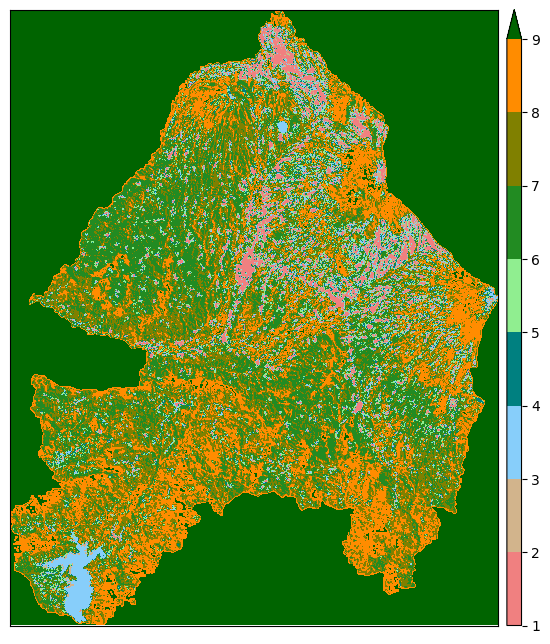

In [12]:
# Predict on image data
image_data = []

used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
print(len(ALL_FEATURES))
print(used_image_feature)
for i in used_image_feature:
    band_data = image.read(i).flatten()
    image_data.append(band_data)

# Create DataFrame for image data
image_df = pd.DataFrame(np.array(image_data).T, columns=FEATURES)

# Convert to TensorFlow dataset
image_ds = tfdf.keras.pd_dataframe_to_tf_dataset(image_df)

# Predict on image data
image_predictions = rf_model.predict(image_ds)
image_predicted_classes = np.argmax(image_predictions, axis=1)

# Reshape predictions to image dimensions
image_predicted_classes = image_predicted_classes.reshape(shape)

# Visualize the predictions
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=(8, 8))
plt.show()